#Scripts de PyPlot para hacer figuras chingonas para poster

Primero, vamos a intentarlo con un experimento que tenga una actividad notoria. Aquí cargamos un archivo que contiene los datos de un experimento con actividad epiléptica. La región CA aparece muy activa varias veces en las mediciones del potencial de campo local, LFP de ahora en adelante.

In [1]:
using PyPlot

INFO: Loading help data...


In [18]:
muacamuaca=open("../Actividad4AP/DatosActividadEpilepticaSelectos.bin", "r")
formaarray=(64,64,5001)
DatosExperimentales=read(muacamuaca, Float64, formaarray);
close(muacamuaca)

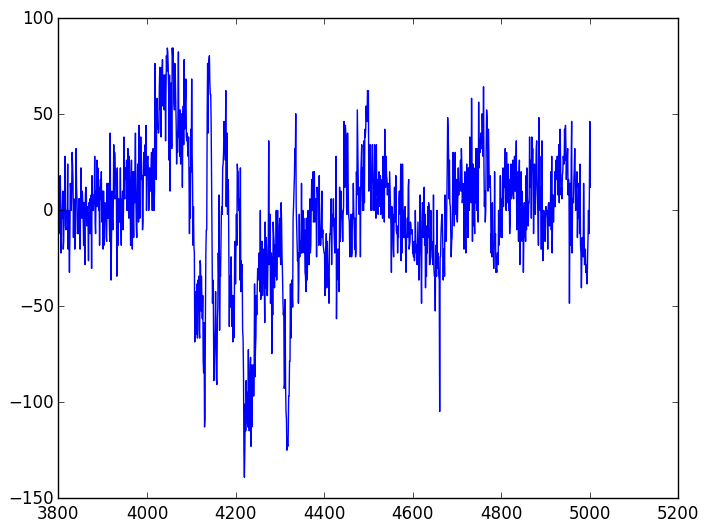

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdf452eba20>

In [27]:
#No todos los datos son interesantes
ion()
intervalo=3800:5001
plot(intervalo, vec(DatosExperimentales[52,40,intervalo]))

In [46]:
#DatosExperimentales=DatosExperimentales[:,:,intervalo];
(alto,ancho,tmax)=size(DatosExperimentales)
map!(x-> abs(x)>1750? 0: x, DatosExperimentales);


In [62]:
puntox=[44,48,52,54,58, 63]
puntoy=[38,42,45,47,50, 54]
puntoy=puntoy+3
puntol=["F","E", "D", "C", "B","A"];

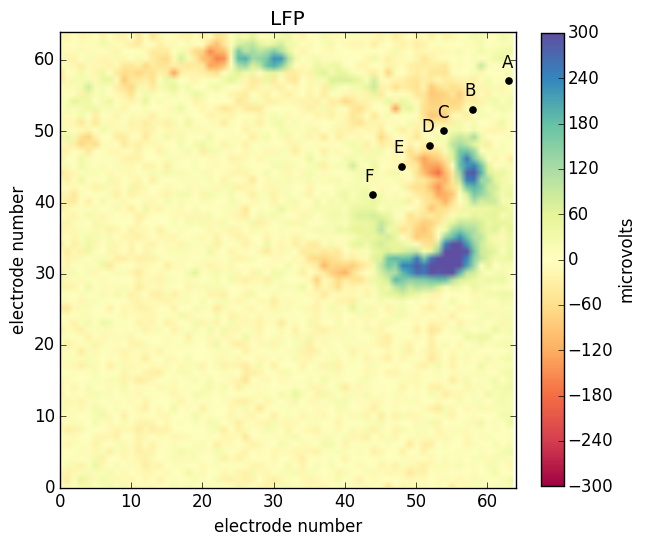

PyObject <matplotlib.text.Text object at 0x7fdf3d9e25f8>

In [63]:
figure(figsize=(6.5,6.5))
title("LFP")
limites=300
PyPlot.xlim(0,64)
PyPlot.ylim(0,64)

for punto in 1:6
    annotate(puntol[punto], (puntox[punto], puntoy[punto]), xytext=(-5,10), textcoords="offset points")
end
imagen=imshow(transpose(DatosExperimentales[:,:,350]), cmap="Spectral", origin="lower", vmin=-limites, vmax=limites)

scatter(puntox,puntoy, marker="o", s=20, c="black")

cbx=colorbar(imagen, fraction=0.045) 
cbx[:set_label]("microvolts")
xlabel("electrode number")
ylabel("electrode number")


Por consistencia, vamos a transponer todos los datos para que las imagenes coincidan con las de Franco

In [64]:
for t=1:tmax
    DatosExperimentales[:,:,t]=transpose(DatosExperimentales[:,:,t])
end

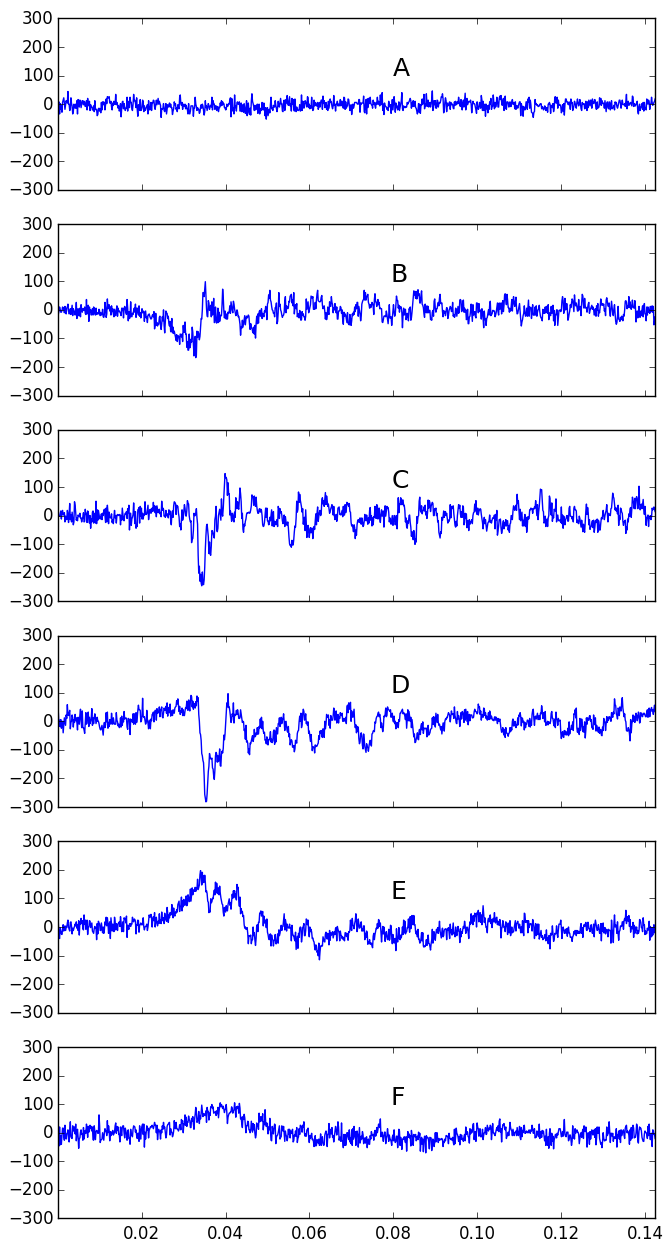

In [71]:
tiempo=1:1000
t=700

farofa, lista=subplots(6, sharex=true, sharey=true, figsize=(7.7,6*2.5))

for j=1:6
    PyPlot.xlim(1/7022,1000/7022)
    PyPlot.ylim(-300,300)
    lista[j][:plot](tiempo/7022,vec(DatosExperimentales[puntoy[7-j],puntox[7-j],tiempo]))
    lista[j][:annotate](puntol[7-j],xy=(0.08,100), annotation_clip=false, fontsize=18)
end

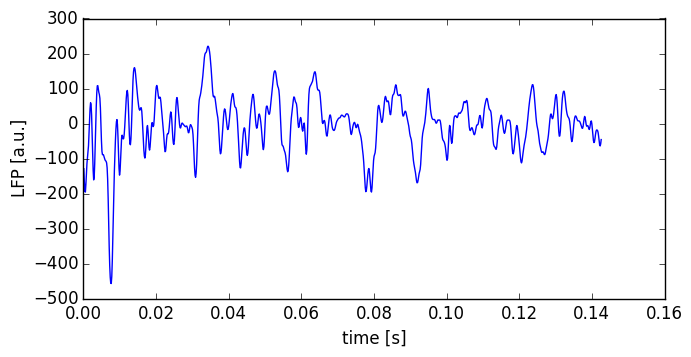

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fcc08089390>

In [5]:
tiempo=1:1001
figure(figsize=(7.5,3.5))
xlabel("time [s]")
ylabel("LFP [a.u.]")
plot(tiempo/7022,ParaMostrarSuave)

In [6]:
function DropPeques(data)
    #solo funciona con data de dos indices.
    renglones,colus=size(data)
    prom=mean(abs(data[3]))
    result=zeros(1,colus)
    for k=1:renglones
        if abs(data[k,3])>prom
            result=vcat(result,data[k,:])
        end
    end
    return result
end

DropPeques (generic function with 1 method)

In [7]:
t=2875
EjemploCentrosCSDPos=readdlm("CentrosMasa/CMPosLapla-$t.dat")
EjemploCentrosCSDPos=DropPeques(EjemploCentrosCSDPos)
xxpos=EjemploCentrosCSDPos[:,1]
yypos=EjemploCentrosCSDPos[:,2]
valorpos=EjemploCentrosCSDPos[:,3]
EjemploCentrosCSDNeg=readdlm("CentrosMasa/CMNegLapla-$t.dat")
EjemploCentrosCSDNeg=DropPeques(EjemploCentrosCSDNeg)
xxneg=EjemploCentrosCSDNeg[:,1]
yyneg=EjemploCentrosCSDNeg[:,2]
valorneg=EjemploCentrosCSDNeg[:,3];
CSDEjemplo=readdlm("CentrosMasa/CSD-$t.dat");

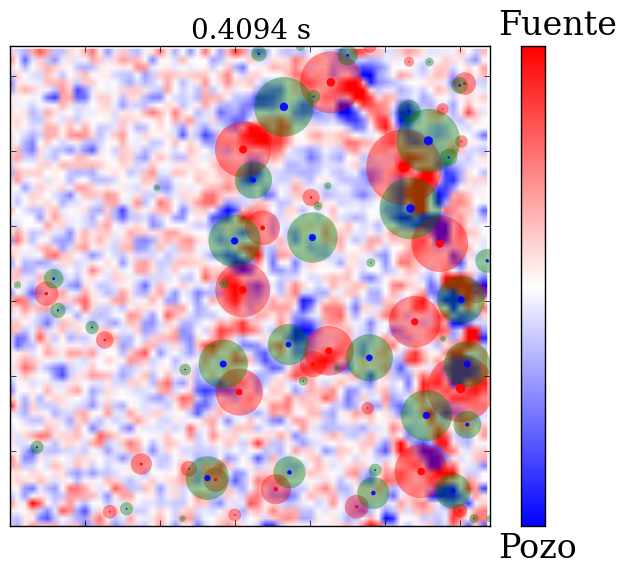

false

In [8]:
PyPlot.ion()
#################
font1 = ["family"=>"DejaVu Serif",
    "color"=>"black",
    "weight"=>"normal",
    "size"=>20]
seg=round(t/7022, 4)
titulo="$seg s"
figure()
PyPlot.xlim(0,64)
PyPlot.ylim(0,64)
tick_params(labelbottom="off", labelleft="off")
otraimagen=imshow(CSDEjemplo, cmap="bwr", origin="lower", vmin=-50, vmax=50)
#cb=colorbar(otraimagen)
#cb=colorbar(otraimagen, ticks=[-150, +150],fraction=0.046, pad=0.04, use_gridspace='True')
cb=colorbar(otraimagen, ticks=[-150, +150], use_gridspec="True")
#farofa=cb[:set_ticklabels]([{"Sink"}, {"Source"}])
#xlabel("furufu", fontdict=font1)

scatter(xxpos,yypos, s=valorpos, alpha=0.4, c="r", edgecolors="none")
scatter(xxneg, yyneg, s=abs(valorneg), alpha=0.4, c="g", edgecolors="none")
scatter(xxpos,yypos, s=0.02*valorpos, alpha=0.9, c="r", edgecolors="none")
scatter(xxneg, yyneg,s=0.02*abs(valorneg), alpha=0.9, c="b", edgecolors="none")


annotate("Pozo",
    xy=[1.05;-0.11],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
font_properties="DejaVu Serif",
    fontsize=24.0,
    ha="left",
    va="bottom")

annotate("Fuente",
    xy=[1.05;0.98],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
font_properties=("DejaVu Serif"),
    fontsize=24,
    ha="left",
   va="bottom")


title(titulo, fontdict=font1)
 #tight_layout()
#savefig("CSDCM_SeminarioAgosto-cb-$t.png", dpi=90)
PyPlot.close_queued_figs()

In [9]:
dedonde, adonde = 1000, 3500
PyPlot.ioff()

In [10]:
@time for t=3176:adonde
    #read the data
    EjemploCentrosCSDPos=readdlm("CentrosMasa/CMPosLapla-$t.dat")
    EjemploCentrosCSDPos=DropPeques(EjemploCentrosCSDPos)
    
    xxpos=EjemploCentrosCSDPos[:,1]
    yypos=EjemploCentrosCSDPos[:,2]
    valorpos=EjemploCentrosCSDPos[:,3]
    EjemploCentrosCSDNeg=readdlm("CentrosMasa/CMNegLapla-$t.dat")
    EjemploCentrosCSDNeg=DropPeques(EjemploCentrosCSDNeg)

    xxneg=EjemploCentrosCSDNeg[:,1]
    yyneg=EjemploCentrosCSDNeg[:,2]
    valorneg=EjemploCentrosCSDNeg[:,3];
    CSDEjemplo=readdlm("CentrosMasa/CSD-$t.dat");
    #plot the data
    lafigura=figure()
    seg=round(t/7022, 4)
    titulo="$seg s"
    PyPlot.xlim(0,63.5)
    PyPlot.ylim(0,63.5)
    
    otraimagen=imshow(CSDEjemplo, cmap="bwr", origin="upper", vmin=-70, vmax=70)
    #cb=colorbar(otraimagen)
    cb=colorbar(otraimagen, ticks=[-150, +150],fraction=0.046, pad=0.04 )
    cb[:set_ticklabels]([{""}, {""}])
    
    cb[:set_ticklabels](["Pozo", "Fuente"])
    cb[:ax][:tick_params](labelsize=12)

    
    scatter(xxpos,yypos, s=valorpos, alpha=0.4, c="r")
    scatter(xxneg, yyneg, s=abs(valorneg), alpha=0.4, c="g")
    scatter(xxpos,yypos, s=0.01*valorpos, alpha=0.95, c="r", edgecolors="none")
    scatter(xxneg, yyneg,s=0.01*abs(valorneg), alpha=0.95, c="b", edgecolors="none")
    #plot(xxpos,yypos, "k+")
    #plot(xxneg, yyneg,"k+")

    title(titulo, fontdict=font1)
    savefig("CentrosMasa/CSD_CM_Agosto-$t.png", dpi=72)
    lafigura[:clf]()
    PyPlot.close()
    lafigura=None
end

elapsed time: 136.182283485 seconds (247855776 bytes allocated, 0.18% gc time)


In [11]:
PyPlot.close()
PyPlot.close_queued_figs()

In [12]:
#guacala de jet. pero les gusta a los Journ. de Neurosc.
PyPlot.ion()
#for t=dedonde+10:adonde
t=732
lala=figure()
tick_params(labelbottom="off", labelleft="off")
b=round(t/7022, 4)
titulo=" $b s"
DatosSuaves=readdlm("GarbageCollector/LFPSuave-$t.dat")
imagen=imshow((DatosSuaves), origin="upper", vmin=-200, vmax=200, interpolation="none")
#cb=colorbar(imagen, ticks=[-200, 0, +200],fraction=0.046, pad=0.04, use_gridspec="True" )
#cb[:set_label]("variación en el potencial [µV]  ", fontsize=20)
cb[:ax][:tick_params](labelsize=20)
title(titulo, fontdict=font1)
tight_layout()
savefig("LFP-$t.png", dpi=90)
PyPlot.close_queued_figs()
gc()
#end

LoadError: opening file GarbageCollector/LFPSuave-732.dat: No existe el fichero o el directorio
while loading In[12], in expression starting on line 9

In [13]:
x=collect(1:64)
y=collect(1:64)
Amplitud=sqrt(EFx.*EFx+EFy.*EFy)
(chico,grande)=extrema(Amplitud)
AmplitudNormalizada=Amplitud/grande
PyPlot.ion()
figure()
xlim(1,64)
ylim(1,64)
#clim(0,120)
flechitas=streamplot(x,y,EFx,EFy, color=AmplitudNormalizada,cmap="Set1", 
density=2, linewidth=2*AmplitudNormalizada);

LoadError: EFx not defined
while loading In[13], in expression starting on line 3